# Cardiotrain project
- Dataset: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset
- EDA
- Data Mining
    - FP Growth
    - Random Forest Permutation importances   
- Modeling
    - 10 fold cross validation
    - SVM
    - some experimenting with GridSearchCV

In [1]:
import numpy as np
import pandas as pd
#!pip install seaborn==0.11.0
import seaborn as sns
import pyfpgrowth
import matplotlib.pyplot as plt
from random import sample

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('C:/Users/Ramello/Documents/CIND840/cardio_train.csv', sep = ';')
backup = df.copy()

## Data dictionary
- Age | Objective Feature | age | int (days) 
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |


# Data Cleaning

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.info()
#no null values in dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


ap_hi = systolic blood pressure; ap_lo = diastolic blood pressure

#### Age is given in days; we will simplify this by converting to years


In [5]:
df.age = df.age//365

In [6]:
df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
5,8,60,1,151,67.0,120,80,2,2,0,0,0,0
6,9,60,1,157,93.0,130,80,3,1,0,0,1,0
7,12,61,2,178,95.0,130,90,3,3,0,0,1,1
8,13,48,1,158,71.0,110,70,1,1,0,0,1,0
9,14,54,1,164,68.0,110,60,1,1,0,0,0,0


In [7]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,52.840671,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,6.766774,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,29.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,64.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


max and min of ap_hi and ap_lo seem like they were typoes given the range from -150 to 16000... it is unlikely those are the real values.

Normal systolic and diastolic blood pressure should be under 180 and 120 respectively. We can reasonably assume that the patients while in examination for this data were not in hypertensive crisis. Therefore all values exceeding those thresholds should be removed.

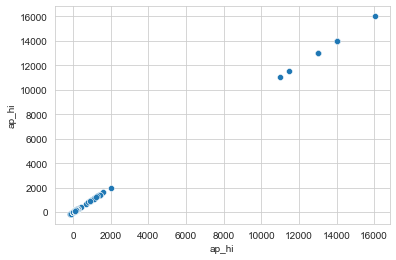

In [8]:
sns.scatterplot(x = df.ap_hi, y = df.ap_hi)

In [9]:
#removing extreme blood pressure values
df = df[df.ap_hi < 180]
df = df[df.ap_lo < 120]

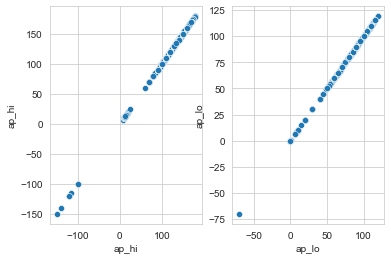

In [10]:
f, axes = plt.subplots(1, 2)

sns.scatterplot(x = df.ap_hi, y = df.ap_hi, ax=axes[0])
sns.scatterplot(x = df.ap_lo, y = df.ap_lo, ax=axes[1])

min values also do not make sense; it isn't possible to have negative blood pressures so these values are removed.

In [11]:
df = df[df.ap_hi > 40]
df = df[df.ap_lo > 40]

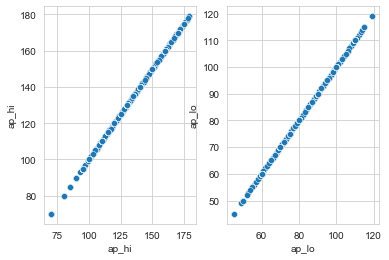

In [12]:
f, axes = plt.subplots(1, 2)

sns.scatterplot(x = df.ap_hi, y = df.ap_hi, ax=axes[0])
sns.scatterplot(x = df.ap_lo, y = df.ap_lo, ax=axes[1])

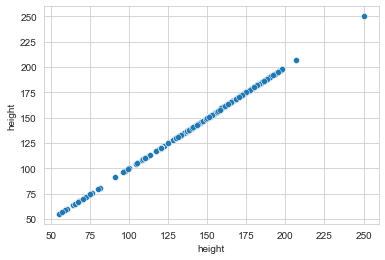

In [13]:
sns.scatterplot(x = df.height, y = df.height)

height also seems to have irregularities in the data. Many are recorded being less than 100cm in height. The minimum age is 29 in this dataset, which makes it unlikely that the heights are true values. 

In [14]:
standarddev = np.std(df.height)
meanheight = np.mean(df.height)

df = df[df.height > (meanheight - 4*standarddev)]
df = df[df.height < (meanheight + 4*standarddev)]

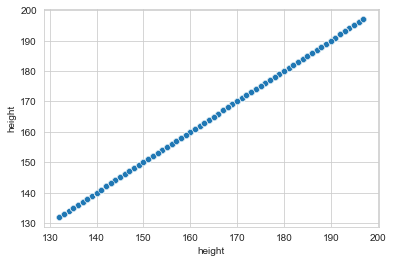

In [15]:
sns.scatterplot(x = df.height, y = df.height)

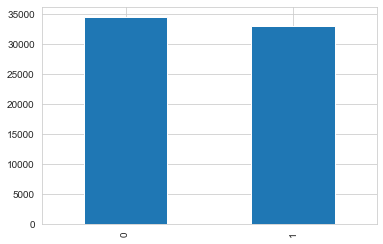

In [16]:
df.cardio.value_counts().plot(kind='bar')
#Cardio is target variable, and is roughly balanced

# Exploratory Data Analysis
- understanding the relationships between variables

In [17]:
df.corr()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,0.003479,0.001999,-0.002823,-0.001267,0.002568,0.000205,0.006453,0.001849,-0.003740,0.000686,0.004203,0.004026
age,0.003479,1.000000,-0.023441,-0.085930,0.053759,0.213092,0.155877,0.153817,0.097992,-0.048319,-0.029257,-0.010343,0.239363
gender,0.001999,-0.023441,1.000000,0.521428,0.158024,0.061164,0.066682,-0.037871,-0.021427,0.338274,0.171000,0.005753,0.005212
height,-0.002823,-0.085930,0.521428,1.000000,0.313489,0.022214,0.039452,-0.056200,-0.021632,0.195816,0.097743,-0.010041,-0.012434
weight,-0.001267,0.053759,0.158024,0.313489,1.000000,0.265272,0.245754,0.138684,0.103819,0.066530,0.066752,-0.017472,0.176051
ap_hi,0.002568,0.213092,0.061164,0.022214,0.265272,1.000000,0.720018,0.193173,0.089695,0.023323,0.030767,0.001729,0.434558
ap_lo,0.000205,0.155877,0.066682,0.039452,0.245754,0.720018,1.000000,0.156106,0.069863,0.021905,0.033899,-0.000271,0.337461
cholesterol,0.006453,0.153817,-0.037871,-0.056200,0.138684,0.193173,0.156106,1.000000,0.450017,0.009690,0.032389,0.009838,0.220902
gluc,0.001849,0.097992,-0.021427,-0.021632,0.103819,0.089695,0.069863,0.450017,1.000000,-0.005484,0.008579,-0.006768,0.088093
smoke,-0.003740,-0.048319,0.338274,0.195816,0.066530,0.023323,0.021905,0.009690,-0.005484,1.000000,0.340096,0.025077,-0.018276


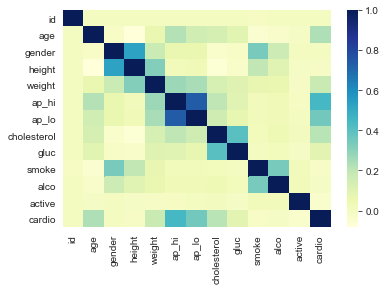

In [18]:
sns.heatmap(df.corr(method = 'spearman'), cmap="YlGnBu")

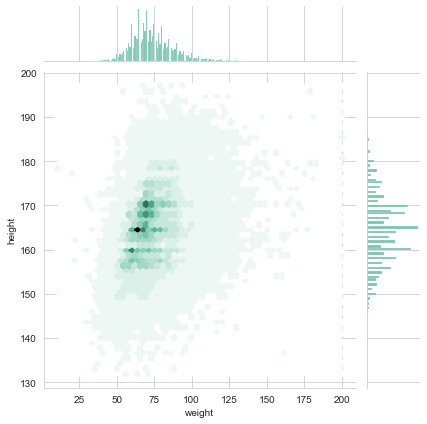

In [19]:
sns.jointplot(x=df.weight, y=df.height, kind="hex", color="#4CB391", bins = 20)

The average patient in this dataset weighs around 75kg and is around 170cm tall.

Text(0.5, 1.0, 'height vs weight')

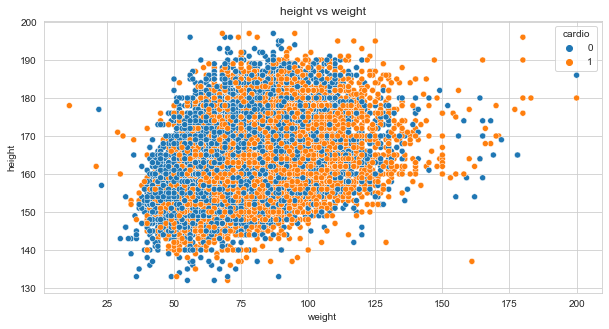

In [20]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = df.weight, y = df.height, hue = df.cardio).set_title("height vs weight")

Text(0.5, 1.0, 'Weight distribution')

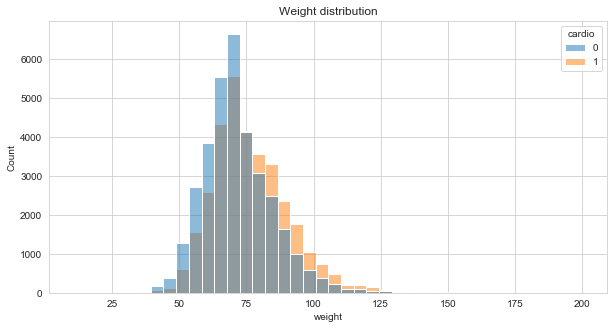

In [21]:
#Weight
plt.figure(figsize=(10,5))
sns.histplot(x = df.weight, hue = df.cardio, bins = 40).set_title("Weight distribution")

Text(0.5, 1.0, 'Height distribution')

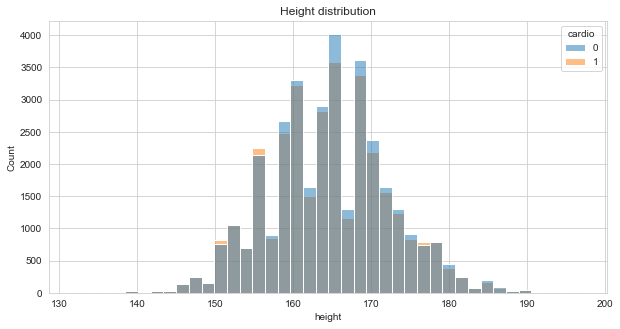

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(x = df.height, hue = df.cardio, bins = 40).set_title("Height distribution")

It looks like more weight increases chance of cardiac arrest, and height is less of an affector

In [23]:
#grouping by gender
mdf = df[df.gender == 1]
fdf = df[df.gender == 2]

## Cholesterol

[Text(0, 0, 'normal'),
 Text(0, 0, 'above normal'),
 Text(0, 0, 'well above normal')]

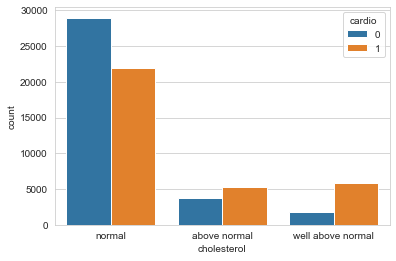

In [24]:
sns.countplot(x = df.cholesterol, hue = df.cardio).set_xticklabels(["normal", "above normal", "well above normal"])

Cholesterol at high levels has a more pronounced effect on cardiac disease

Text(0.5, 1.0, 'Females')

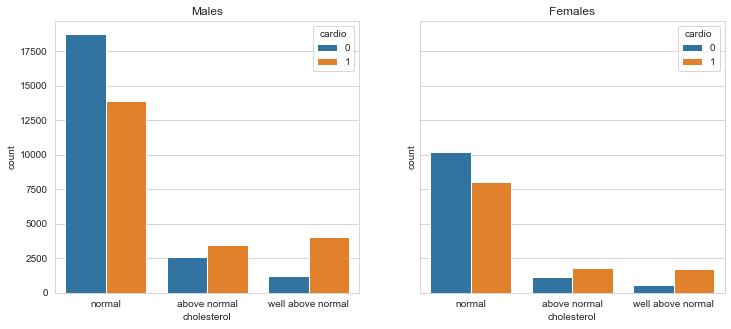

In [25]:
f, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.countplot(x = mdf.cholesterol, hue = mdf.cardio, ax=axes[0]).set_xticklabels(["normal", "above normal", "well above normal"])
sns.countplot(x = fdf.cholesterol, hue = fdf.cardio, ax=axes[1]).set_xticklabels(["normal", "above normal", "well above normal"])
axes[0].set_title("Males")
axes[1].set_title("Females")

## Glucose

[Text(0, 0, 'normal'),
 Text(0, 0, 'above normal'),
 Text(0, 0, 'well above normal')]

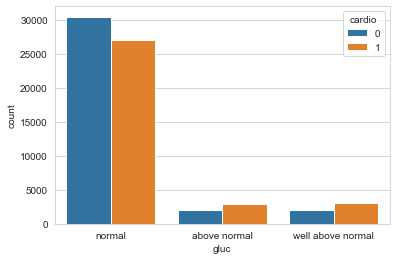

In [26]:
sns.countplot(x = df.gluc, hue = df.cardio).set_xticklabels(["normal", "above normal", "well above normal"])

Elevated glucose levels also look to result in more cardiac disease, but not as significantly as cholesterol. Cholesterol and glucose are moderately correlated with the spearman coefficient of ~0.4

## Smoking

Text(0.5, 1.0, 'Females')

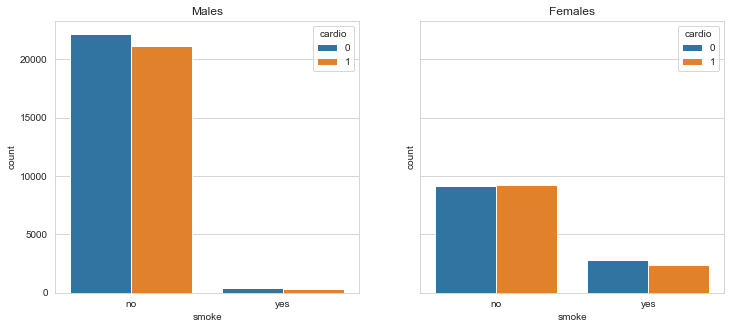

In [27]:
f, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.countplot(x = mdf.smoke, hue = mdf.cardio, ax=axes[0]).set_xticklabels(["no", "yes"])
sns.countplot(x = fdf.smoke, hue = fdf.cardio, ax=axes[1]).set_xticklabels(["no", "yes"])
axes[0].set_title("Males")
axes[1].set_title("Females")

## Alcohol consumption

Text(0.5, 1.0, 'Females')

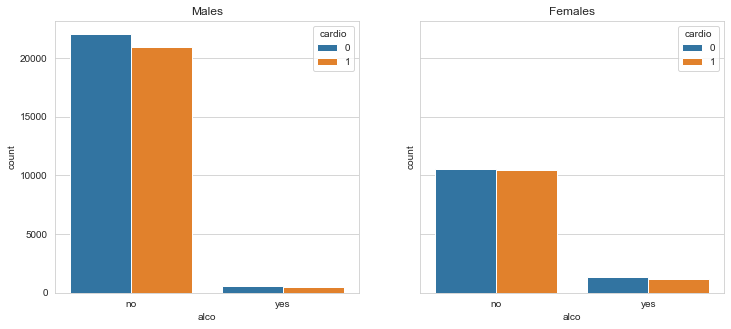

In [28]:
f, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.countplot(x = mdf.alco, hue = mdf.cardio, ax=axes[0]).set_xticklabels(["no", "yes"])
sns.countplot(x = fdf.alco, hue = fdf.cardio, ax=axes[1]).set_xticklabels(["no", "yes"])
axes[0].set_title("Males")
axes[1].set_title("Females")

## Physical activity 

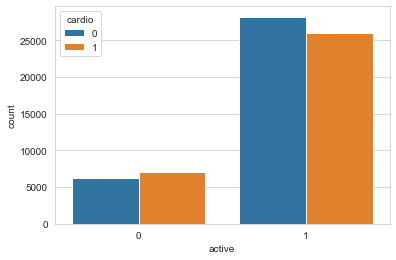

In [29]:
sns.countplot(x = df.active, hue = df.cardio)

## Age

Text(0.5, 1.0, 'age distribution')

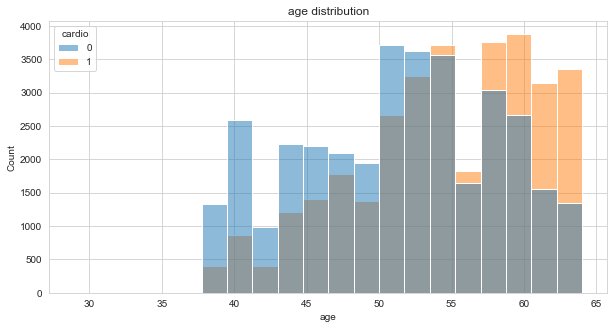

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(x = df.age, hue = df.cardio, bins = 20).set_title("age distribution")

Older folks tend to have higher likelihood of cardiac disease

In [31]:
#subsetting active and not-active 
ndf = df[df.active==0]
adf = df[df.active==1]

Text(0.5, 1.0, 'age distribution for active population')

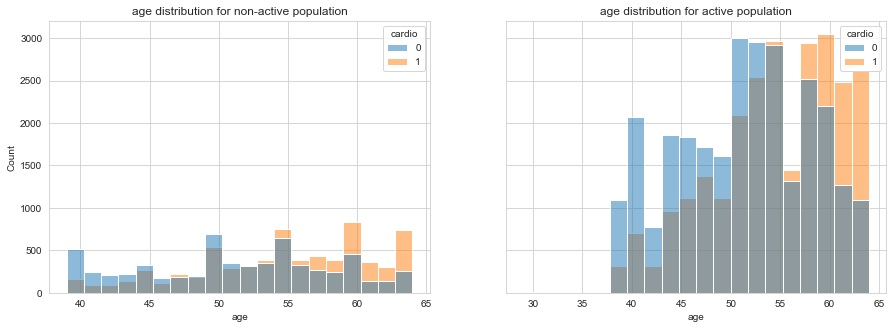

In [32]:
f, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)

sns.histplot(x = ndf.age, hue = ndf.cardio, bins = 20, ax=axes[0]).set_title("age distribution for non-active population")
sns.histplot(x = adf.age, hue = adf.cardio, bins = 20, ax=axes[1]).set_title("age distribution for active population")

Cannot suggest cardiovascular risk from this data when the non-active subset is much smaller than the active population.

Text(0.5, 1.0, 'ap_hi vs ap_lo')

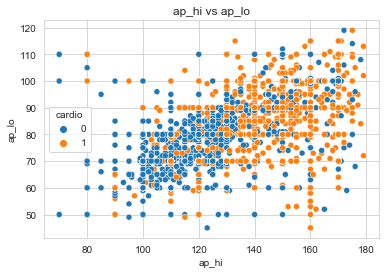

In [33]:
#ap_hi and ap_lo
sns.scatterplot(x = df.ap_hi, y = df.ap_lo, hue = df.cardio).set_title("ap_hi vs ap_lo")

In [34]:
df[df.ap_hi==df.ap_hi.max()]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
5465,7770,53,1,162,67.0,179,113,1,2,0,0,0,1
14134,20177,59,2,173,128.0,179,113,1,1,1,1,1,1
21991,31406,56,1,161,88.0,179,102,1,2,0,0,1,1
39296,56128,59,1,160,101.0,179,72,3,2,0,0,1,1


Text(0.5, 1.0, 'ap_hi distribution')

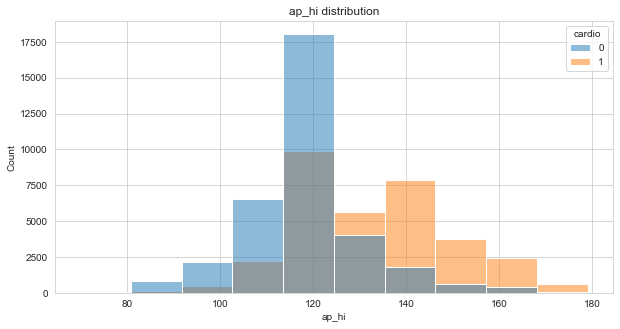

In [35]:
plt.figure(figsize=(10,5))
sns.histplot(x = df.ap_hi, hue = df.cardio, bins = 10).set_title("ap_hi distribution")

Text(0.5, 1.0, 'ap_lo distribution')

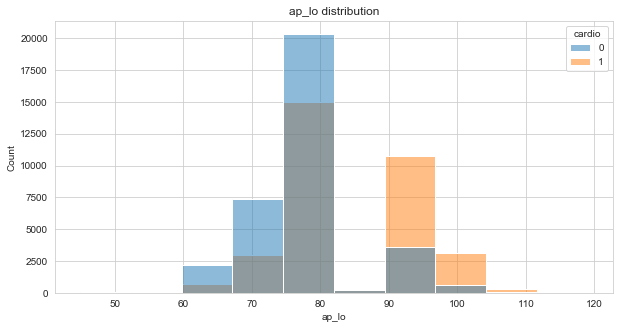

In [36]:
plt.figure(figsize=(10,5))
sns.histplot(x = df.ap_lo, hue = df.cardio, bins = 10).set_title("ap_lo distribution")

Both generally see increase in cardiovascular disease presence at higher numbers

# Feature generation
- using ap_hi/ap_lo for blood pressure
- using height/weight for BMI

### Blood Pressure
- if systolic is less than 120 and diastolic is less than 80 = normal BP
- if systolic is less than 129 and diastolic is less than 80 = elevated
- if systolic is less than 139 and diastolic is less than 89 = stage 1 high blood pressure
- if systolic is less than 180 and diastolic is less than 120 = stage 2 high BP

In [37]:
bpconditions = [
    (df.ap_hi < 120) & (df.ap_lo <= 80),
    (df.ap_hi < 129) & (df.ap_lo < 80),
    (df.ap_hi < 139) & (df.ap_lo < 89),
    (df.ap_hi <= 180) & (df.ap_lo <= 120) 
]

bpvalues = ["Normal BP", "Elevated BP", "Stage 1 High BP", "Stage 2 High BP"]
df['Blood Pressure'] = np.select(bpconditions, bpvalues)

Text(0.5, 1.0, 'BP distribution')

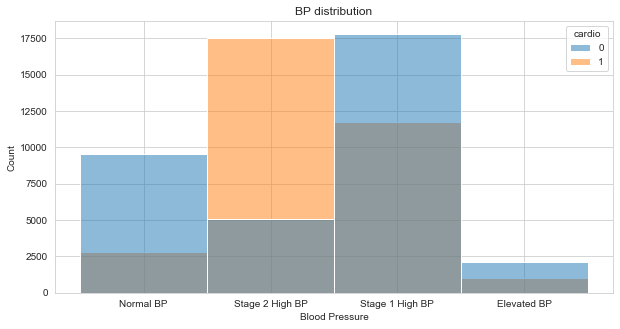

In [38]:
plt.figure(figsize=(10,5))
sns.histplot(x = df['Blood Pressure'], hue = df.cardio).set_title("BP distribution")

In [39]:
#creating BMI variable 
df['BMI'] = df.weight / (df.height/100)**2

In [40]:
df.BMI.describe()

count    67582.000000
mean        27.386227
std          5.159612
min          3.471784
25%         23.875115
50%         26.291724
75%         30.103806
max         85.779743
Name: BMI, dtype: float64

Text(0.5, 1.0, 'BMI distribution')

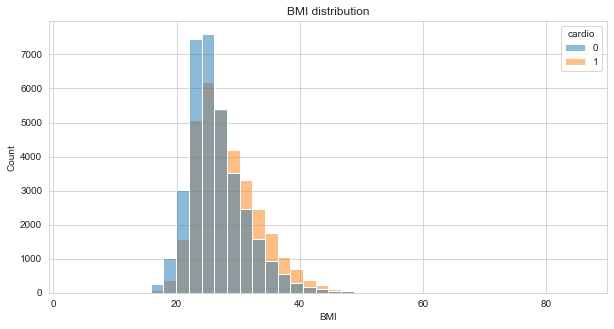

In [41]:
#BMI
plt.figure(figsize=(10,5))
sns.histplot(x = df.BMI, hue = df.cardio, bins = 40).set_title("BMI distribution")

In [42]:
df = df[df.BMI < 50] #removing outliers

Higher BMI = more risk of cardiovascular disease

# Data Mining
- Data Mining using feature_importances and permutation_importance with Random Forest
- FPGrowth

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, mean_absolute_error, classification_report
from sklearn import preprocessing
from sklearn.inspection import permutation_importance
from math import sqrt

In [134]:
def featimportances(X, y):
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

    clf = RandomForestClassifier(random_state=1)
    clf = clf.fit(train_X, train_y)
    val_pred = clf.predict(val_X)
    val_rmse = sqrt(mean_squared_error(val_pred, val_y))
    val_mae = mean_absolute_error(val_pred, val_y)

    print('Model scores:')
    print(f'R^2: {clf.score(train_X, train_y):.2f}\nValidation RMSE: {val_rmse:.2f} \nValidation MAE: {val_mae:.2f}')
    print("auROC score:", round(roc_auc_score(val_y, val_pred),2),'\n')
    print(classification_report(val_y, val_pred),'\n')

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    for f in range (train_X.shape[1]):
        featurelist = []
        featurelist.append(X.columns[indices[f]])
        print(f + 1,"\t", X.columns[indices[f]], importances[indices[f]])

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(train_X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(train_X.shape[1]), indices)
    plt.xlim([-1, train_X.shape[1]])
    plt.show()

    from sklearn.inspection import permutation_importance

    #Permutation importances
    print('Permutation Importances')
    a,b,c = [],[],[]
    r = permutation_importance(clf, val_X, val_y)
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            a.append(r.importances_mean[i])
            b.append(str(i+1))
            c.append(r.importances_std[i])
            print(f"{i+1} \t"
                  f"{X.columns[i]:<8} \t"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

    plt.figure(figsize=(12,8))
    plt.title("Permutation importances")
    plt.bar(b, a, yerr=c, color="r", align="center")
    plt.xticks(b)
    plt.show()

Model scores:
R^2: 0.98
Validation RMSE: 0.55 
Validation MAE: 0.30
auROC score: 0.7 

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      8565
           1       0.70      0.68      0.69      8296

    accuracy                           0.70     16861
   macro avg       0.70      0.70      0.70     16861
weighted avg       0.70      0.70      0.70     16861
 

Feature ranking:
1 	 BMI 0.1906667774744718
2 	 ap_hi 0.17849925328829197
3 	 age 0.16324198642171853
4 	 weight 0.13856279713480715
5 	 height 0.13186765228615602
6 	 ap_lo 0.08449078593520648
7 	 cholesterol 0.03959029773786482
8 	 gender 0.02006664008646105
9 	 gluc 0.018605410887384117
10 	 active 0.01630605901061295
11 	 smoke 0.010077288219800438
12 	 alco 0.008025051517224617


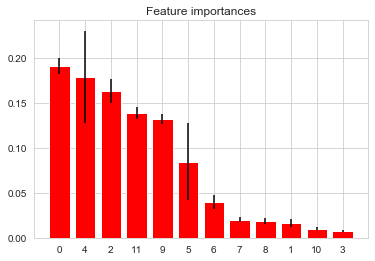

Permutation Importances
5 	ap_hi    	0.130 +/- 0.004
7 	cholesterol 	0.030 +/- 0.002
3 	age      	0.023 +/- 0.003
4 	alco     	0.001 +/- 0.000


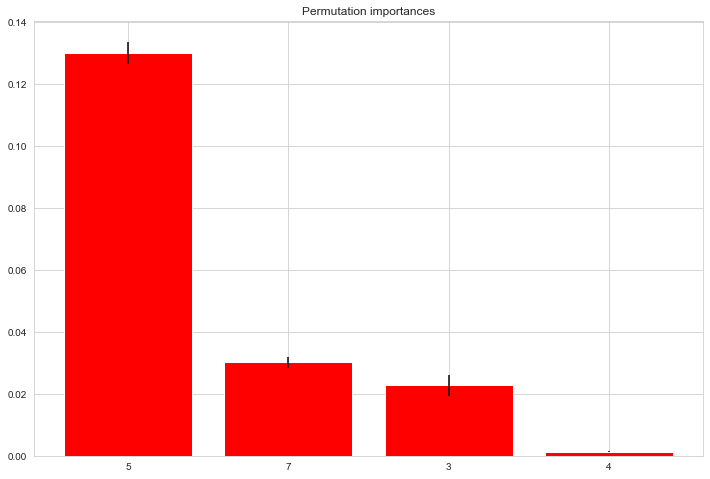

In [135]:
y1 = df.cardio
X1 = df[df.columns.difference(['cardio','id','Blood Pressure'])]

featimportances(X1,y1)

Systolic blood pressure is the most important, followed by cholesterol and age. However blood pressure columns are tricky because they may also be a symptom of cardiovascular disease, thus a false indicator and can skew results to be more accurate than should be

Model scores:
R^2: 0.93
Validation RMSE: 0.63 
Validation MAE: 0.40
auROC score: 0.6 

              precision    recall  f1-score   support

           0       0.60      0.61      0.61      8565
           1       0.59      0.58      0.59      8296

    accuracy                           0.60     16861
   macro avg       0.60      0.60      0.60     16861
weighted avg       0.60      0.60      0.60     16861
 

Feature ranking:
1 	 BMI 0.26629120663222483
2 	 age 0.2430207937942065
3 	 weight 0.17589232356301301
4 	 height 0.172304109888405
5 	 cholesterol 0.0498509816938779
6 	 gender 0.023781281348077655
7 	 gluc 0.023319644042598453
8 	 active 0.019137887170531068
9 	 smoke 0.014227931934148827
10 	 alco 0.012173839932916722


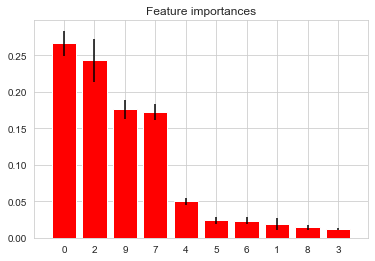

Permutation Importances
3 	age      	0.038 +/- 0.002
5 	cholesterol 	0.031 +/- 0.002


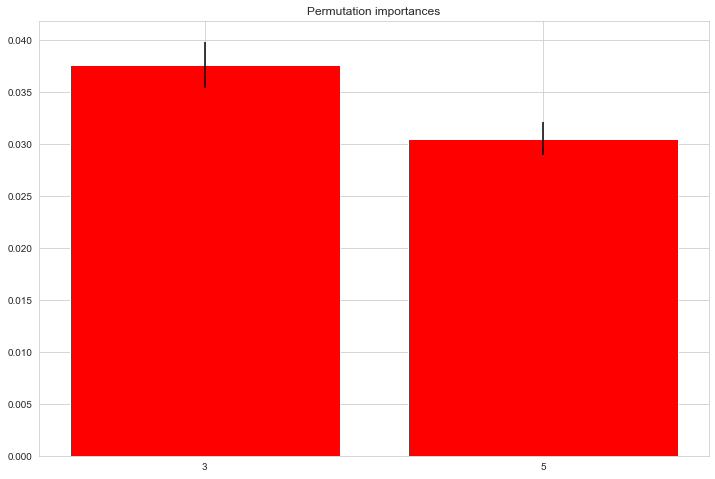

In [136]:
y2 = df.cardio
X2 = df[df.columns.difference(['cardio','id','Blood Pressure','ap_hi','ap_lo'])]

featimportances(X2, y2)

Model scores:
R^2: 0.93
Validation RMSE: 0.64 
Validation MAE: 0.41
auROC score: 0.59 

              precision    recall  f1-score   support

           0       0.60      0.61      0.61      8565
           1       0.59      0.57      0.58      8296

    accuracy                           0.59     16861
   macro avg       0.59      0.59      0.59     16861
weighted avg       0.59      0.59      0.59     16861
 

Feature ranking:
1 	 weight 0.331665730506899
2 	 height 0.32444531446317104
3 	 age 0.21564431939276327
4 	 cholesterol 0.051302805122317746
5 	 gluc 0.02079328642674551
6 	 gender 0.018880507748286687
7 	 active 0.014688475978514921
8 	 smoke 0.011751120263147275
9 	 alco 0.010828440098154516


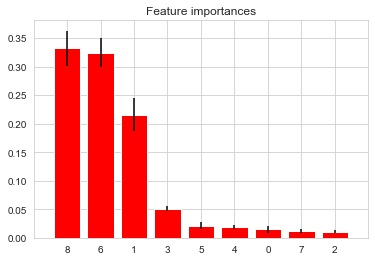

Permutation Importances
4 	cholesterol 	0.036 +/- 0.003
2 	age      	0.035 +/- 0.003
9 	weight   	0.020 +/- 0.002


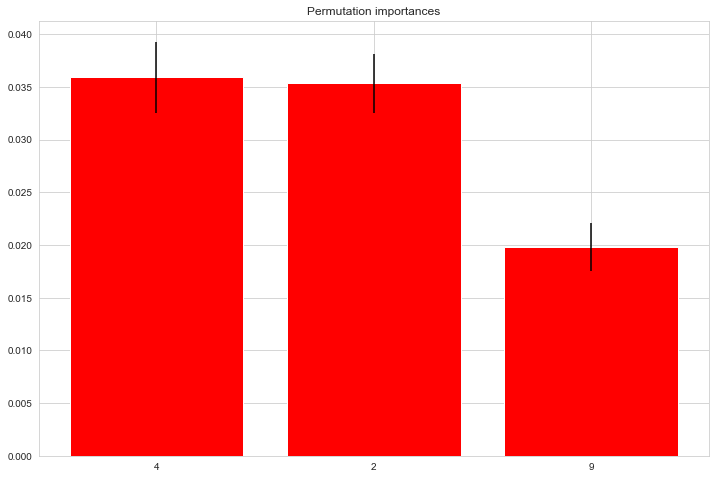

In [137]:
y3 = df.cardio
X3 = df[df.columns.difference(['cardio','id','Blood Pressure','BMI','ap_hi','ap_lo'])]
#feature generation may poorly bucketize categories and lose nuance in data; removed BMI as well

featimportances(X3, y3)

- cholesterol and age seems to be a constant in each model, followed by weight

# FPGrowth Preprocessing
- First preprocessing of the dataset to categorical variables (bucketizing continuous variables/large range)
- Age will be bucketized, and the categorical variables will be factored to improve readability of results
- height and weight will be combined and binned for BMI
- ap_hi and ap_lo will be combined and binned for blood pressure
- binning is only for purposes of FPGrowth, these columns will not be used for modelling

In [50]:
fpdf = df.copy()

In [51]:
fpdf.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Blood Pressure,BMI
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,Normal BP,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,Stage 2 High BP,34.927679
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,Stage 1 High BP,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,Stage 2 High BP,28.710479
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,Normal BP,23.011177


In [52]:
#age 
fpdf.age.describe()
#29 to 64

count    67442.000000
mean        52.794134
std          6.774067
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

In [53]:
fpdf.age = pd.cut(fpdf.age, [29,40,55,70], labels = ["Age: 29-40","Age: 41-55","Age: 56+"])

### BMI
- Underweight = 18 or below,
- Healthy = 19-24,
- Overweight = 25-29,
- Obese = 30-39,
- Morbidly obese = 40+

In [54]:
fpdf.BMI = pd.cut(fpdf.BMI, [0,18,25,30,40,100], labels = ["Underweight",'Healthy weight','Overweight','Obese','Morbidly obese'])

In [55]:
fpdf.drop(columns=["height","weight","ap_hi","ap_lo"], inplace=True) 
#These columns will be dropped and the generated feature will be used

In [56]:
fpdf.tail()

,id,age,gender,cholesterol,gluc,smoke,alco,active,cardio,Blood Pressure,BMI
69993,99991,Age: 41-55,1,1,1,0,0,1,1,Stage 2 High BP,Healthy weight
69994,99992,Age: 56+,1,1,1,0,0,1,1,Stage 2 High BP,Overweight
69995,99993,Age: 41-55,2,1,1,1,0,1,0,Stage 1 High BP,Overweight
69998,99998,Age: 56+,1,1,2,0,0,0,1,Stage 1 High BP,Overweight
69999,99999,Age: 56+,1,2,1,0,0,1,0,Stage 1 High BP,Healthy weight


In [57]:
df.tail() #checking if encoding was done correctly

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Blood Pressure,BMI
69993,99991,53,1,172,70.0,130,90,1,1,0,0,1,1,Stage 2 High BP,23.661439
69994,99992,57,1,165,80.0,150,80,1,1,0,0,1,1,Stage 2 High BP,29.384757
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0,Stage 1 High BP,26.927438
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,Stage 1 High BP,27.099251
69999,99999,56,1,170,72.0,120,80,2,1,0,0,1,0,Stage 1 High BP,24.913495


## Categorical encoding
- the purpose of this step is to make the output of FPGrowth more easily interpretable
- however, for modeling, this step will be reverted

In [58]:
cdf = fpdf.copy()
di = {1: "Male", 2: "Female"}
chdi = {1: "Normal cholesterol", 2:"Above average cholesterol", 3:"Well above average cholesterol"}
gldi = {1: "Normal glucose", 2:"Above average glucose", 3:"Well above average glucose"}
smdi = {0: "Non-smoker", 1: "Smoker"}
aldi = {0: "Drinks alcohol", 1: "Does not drink"}
acdi = {0: "Not physically active", 1: "Physically active"}
cadi = {0: "No cardiovascular disease", 1: "Presence of cardiovascular disease"}
cdf.replace({"gender": di}, inplace=True)
cdf.replace({"cholesterol": chdi}, inplace=True)
cdf.replace({"gluc": gldi}, inplace=True)
cdf.replace({"smoke": smdi}, inplace=True)
cdf.replace({"alco": aldi}, inplace=True)
cdf.replace({"active": acdi}, inplace=True)
cdf.replace({"cardio": cadi}, inplace=True)

In [126]:
cdf.head(5)

,id,age,gender,cholesterol,gluc,smoke,alco,active,cardio,Blood Pressure,BMI
0,0,Age: 41-55,Female,Normal cholesterol,Normal glucose,Non-smoker,Drinks alcohol,Physically active,No cardiovascular disease,Normal BP,Healthy weight
1,1,Age: 41-55,Male,Well above average cholesterol,Normal glucose,Non-smoker,Drinks alcohol,Physically active,Presence of cardiovascular disease,Stage 2 High BP,Obese
2,2,Age: 41-55,Male,Well above average cholesterol,Normal glucose,Non-smoker,Drinks alcohol,Not physically active,Presence of cardiovascular disease,Stage 1 High BP,Healthy weight
3,3,Age: 41-55,Female,Normal cholesterol,Normal glucose,Non-smoker,Drinks alcohol,Physically active,Presence of cardiovascular disease,Stage 2 High BP,Overweight
4,4,Age: 41-55,Male,Normal cholesterol,Normal glucose,Non-smoker,Drinks alcohol,Not physically active,No cardiovascular disease,Normal BP,Healthy weight


# FPGrowth Modeling

In [60]:
import pyfpgrowth

In [61]:
#FPGrowth is a time consuming algorithm. The dataset is sampled to save time
FPGdf = cdf.sample(1000)

In [67]:
patterns = pyfpgrowth.find_frequent_patterns(FPGdf.values.tolist(),30)
{key: patterns[key] for key in list(patterns.keys())[:10]}

{('Age: 41-55', 'Drinks alcohol', 'Elevated BP'): 31,
 ('Age: 41-55', 'Drinks alcohol', 'Elevated BP', 'Non-smoker'): 31,
 ('Age: 41-55', 'Drinks alcohol', 'Elevated BP', 'Normal glucose'): 30,
 ('Age: 41-55',
  'Drinks alcohol',
  'Elevated BP',
  'Non-smoker',
  'Normal glucose'): 30,
 ('Age: 41-55', 'Elevated BP', 'Normal glucose'): 32,
 ('Age: 41-55', 'Elevated BP', 'Non-smoker'): 32,
 ('Age: 41-55', 'Elevated BP', 'Non-smoker', 'Normal glucose'): 31,
 ('Elevated BP', 'Normal cholesterol', 'Physically active'): 31,
 ('Drinks alcohol',
  'Elevated BP',
  'Normal cholesterol',
  'Physically active'): 30,
 ('Elevated BP', 'Non-smoker', 'Normal cholesterol', 'Physically active'): 30}

In [68]:
rules = pyfpgrowth.generate_association_rules(patterns, 0.7)
{key: rules[key] for key in list(rules.keys())[:10]}

{('Drinks alcohol', 'Elevated BP'): (('Non-smoker',), 1.0),
 ('Elevated BP', 'Non-smoker'): (('Drinks alcohol',), 0.9761904761904762),
 ('Age: 41-55',
  'Drinks alcohol',
  'Elevated BP'): (('Non-smoker', 'Normal glucose'), 0.967741935483871),
 ('Age: 41-55', 'Elevated BP', 'Non-smoker'): (('Normal glucose',), 0.96875),
 ('Drinks alcohol', 'Elevated BP', 'Non-smoker'): (('Normal glucose',),
  0.926829268292683),
 ('Elevated BP', 'Normal glucose'): (('Drinks alcohol', 'Non-smoker'), 0.95),
 ('Age: 41-55', 'Elevated BP', 'Normal glucose'): (('Non-smoker',), 0.96875),
 ('Drinks alcohol', 'Elevated BP', 'Normal glucose'): (('Non-smoker',), 1.0),
 ('Elevated BP', 'Non-smoker', 'Normal glucose'): (('Drinks alcohol',),
  0.9743589743589743),
 ('Age: 41-55',
  'Drinks alcohol',
  'Elevated BP',
  'Non-smoker'): (('Normal glucose',), 0.967741935483871)}

I am interested in seeing the relationships with presence of cardiovascular disease

In [69]:
pdf = FPGdf[FPGdf.cardio=="Presence of cardiovascular disease"]
patterns = pyfpgrowth.find_frequent_patterns(pdf.values.tolist(),50)
rules = pyfpgrowth.generate_association_rules(patterns, 0.7)
{key: rules[key] for key in list(rules.keys())[:10]}

{('Above average cholesterol',
  'Non-smoker'): (('Drinks alcohol',
   'Presence of cardiovascular disease'), 0.9411764705882353),
 ('Above average cholesterol',
  'Drinks alcohol'): (('Presence of cardiovascular disease',), 1.0),
 ('Above average cholesterol',
  'Drinks alcohol',
  'Non-smoker'): (('Presence of cardiovascular disease',), 1.0),
 ('Above average cholesterol',
  'Drinks alcohol',
  'Normal glucose'): (('Presence of cardiovascular disease',), 1.0),
 ('Above average cholesterol',
  'Non-smoker',
  'Normal glucose'): (('Drinks alcohol', 'Presence of cardiovascular disease'),
  0.9629629629629629),
 ('Above average cholesterol',
  'Presence of cardiovascular disease'): (('Drinks alcohol',), 0.9459459459459459),
 ('Above average cholesterol',
  'Non-smoker',
  'Presence of cardiovascular disease'): (('Drinks alcohol',),
  0.9411764705882353),
 ('Above average cholesterol',
  'Normal glucose',
  'Presence of cardiovascular disease'): (('Drinks alcohol',),
  0.9655172413793104)

In [71]:
#Only view rules where the consequent == Cardiovascular disease
cardiovasc_rules = [k for k in rules if rules.get(k) == (('Presence of cardiovascular disease',), 1.0)]
cardiovasc_rules[:10]

[('Above average cholesterol', 'Drinks alcohol'),
 ('Above average cholesterol', 'Drinks alcohol', 'Non-smoker'),
 ('Above average cholesterol', 'Drinks alcohol', 'Normal glucose'),
 ('Above average cholesterol',
  'Drinks alcohol',
  'Non-smoker',
  'Normal glucose'),
 ('Above average cholesterol', 'Drinks alcohol', 'Physically active'),
 ('Above average cholesterol',
  'Drinks alcohol',
  'Non-smoker',
  'Physically active'),
 ('Normal glucose', 'Well above average cholesterol'),
 ('Age: 56+', 'Drinks alcohol', 'Well above average cholesterol'),
 ('Age: 56+', 'Non-smoker', 'Well above average cholesterol'),
 ('Male', 'Non-smoker', 'Well above average cholesterol')]

From the rules, I can interpret that some combination of morbid obesity, high glucose levels, high cholesterol, high blood pressure, smoking, alcohol use and being male increases the chances of cardiovascular disease.

# Logistic Regression
- for comparison of performance to SVM

In [138]:
logr = LR(random_state = 1, solver='liblinear')

min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(X)

logr.fit(df_scaled, y.squeeze())

val_X_scaled = min_max_scaler.transform(val_X)
results = logr.predict(val_X_scaled)

[[6753 1812]
 [2835 5461]]
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      8565
           1       0.75      0.66      0.70      8296

    accuracy                           0.72     16861
   macro avg       0.73      0.72      0.72     16861
weighted avg       0.73      0.72      0.72     16861



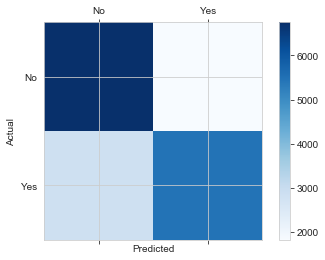

In [140]:
cm = confusion_matrix(val_y, results)
print(cm)
print(classification_report(val_y, results))

labels = ['No', 'Yes']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SVM Classification

## SVM Preprocessing
- onehot encoding for initial categorical variables


In [47]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,Blood Pressure,BMI
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,Normal BP,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,Stage 2 High BP,34.927679
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,Stage 1 High BP,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,Stage 2 High BP,28.710479
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,Normal BP,23.011177


For the first trial, we will use the original dataset features; ie. excluding generated features like Blood Pressure and BMI

In [48]:
svm_df = df[df.columns[0:13]]

In [49]:
svm_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


### One Hot Encoding

In [50]:
y = svm_df.cardio
X = svm_df[svm_df.columns.difference(['cardio', 'id'])]

In [51]:
cols = ['gender']
ohdf = X.copy()
ohdf = pd.get_dummies(X, columns = cols, prefix = cols)
ohdf

,active,age,alco,ap_hi,ap_lo,cholesterol,gluc,height,smoke,weight,gender_1,gender_2
0,1,50,0,110,80,1,1,168,0,62.0,0,1
1,1,55,0,140,90,3,1,156,0,85.0,1,0
2,0,51,0,130,70,3,1,165,0,64.0,1,0
3,1,48,0,150,100,1,1,169,0,82.0,0,1
4,0,47,0,100,60,1,1,156,0,56.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69993,1,53,0,130,90,1,1,172,0,70.0,1,0
69994,1,57,0,150,80,1,1,165,0,80.0,1,0
69995,1,52,0,120,80,1,1,168,1,76.0,0,1
69998,0,61,0,135,80,1,2,163,0,72.0,1,0


In [52]:
ohdf['cardio'] = y
ohdf

,active,age,alco,ap_hi,ap_lo,cholesterol,gluc,height,smoke,weight,gender_1,gender_2,cardio
0,1,50,0,110,80,1,1,168,0,62.0,0,1,0
1,1,55,0,140,90,3,1,156,0,85.0,1,0,1
2,0,51,0,130,70,3,1,165,0,64.0,1,0,1
3,1,48,0,150,100,1,1,169,0,82.0,0,1,1
4,0,47,0,100,60,1,1,156,0,56.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,1,53,0,130,90,1,1,172,0,70.0,1,0,1
69994,1,57,0,150,80,1,1,165,0,80.0,1,0,1
69995,1,52,0,120,80,1,1,168,1,76.0,0,1,0
69998,0,61,0,135,80,1,2,163,0,72.0,1,0,1


## 10-fold cross validation
- due to computation time only 5000 rows are sampled
- test and train set size will be 0.3:0.7
- 10 fold cross validation will be done on the train set

In [53]:
#df is sampled to reduce computation time
sdf = ohdf.sample(5000, random_state=4)

In [54]:
sdf.cardio.value_counts() #target variable is roughly balanced

0    2534
1    2466
Name: cardio, dtype: int64

## 10-fold cross validation: Kernel comparison
- split training/test set 
- 10 fold validation only on training set
- testing kernel hyperparameters
- test set is held out until final model evaluation

In [55]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import SVC
from scipy.stats import friedmanchisquare

In [56]:
#slightly smaller test_size to accomodate larger validation set for hyperparameter tuning
train_set, test_set = train_test_split(sdf, test_size=0.2, random_state=0)

In [57]:
#10 fold validation
kf = KFold(n_splits=10, shuffle=True, random_state=0)

In [98]:
def cv(train_X, train_y, kernels = ['rbf', 'linear', 'poly'], metric = ['accuracy','precision','recall','roc_auc']):
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    scores = {}
    for m in metric:
        for k in kernels:
            svm_model = SVC(kernel = k)
            scores[k] = list(cross_val_score(svm_model, train_X, train_y, scoring=m, cv=kf))
            
        print("10-Fold CV average: ", m, '\n')
        for x in scores: 
            print(f'{x}: {np.mean(scores.get(x)):.3f}')
        
        stat, p = friedmanchisquare(scores['rbf'], scores['linear'], scores['poly'])
        print('\n','p-value:', p,'\n')

In [99]:
y = train_set.cardio
X = train_set[train_set.columns.difference(['cardio'])]

cv(X, y)
#friedman test compares the results for each metric

10-Fold CV average:  accuracy 

rbf: 0.713
linear: 0.720
poly: 0.715

 p-value: 0.3225236063732963 

10-Fold CV average:  precision 

rbf: 0.768
linear: 0.767
poly: 0.779

 p-value: 0.024723526470339326 

10-Fold CV average:  recall 

rbf: 0.598
linear: 0.621
poly: 0.587

 p-value: 0.00030353913807886407 

10-Fold CV average:  roc_auc 

rbf: 0.778
linear: 0.789
poly: 0.780

 p-value: 0.003345965457471265 



friedman test p value shows that results for each is significant except for accuracy. This is to say that at least one distribution is truly different from the others in precision, recall and roc_auc.

For this case, in diagnoses of a disease it may be beneficial to focus on recall and auROC for true positive classification.
Therefore, linear kernel looks to be the most useful in this case.

## SVM Model

In [108]:
from sklearn.metrics import classification_report, roc_auc_score

In [102]:
def modeltest(X, y, X_test, y_test, kernels = ['rbf','linear','poly']):
    #for k in kernels:
    svm_es = SVC(kernel = 'linear')
    model = svm_es.fit(X, y) #fitting on train_set
    ypred = model.predict(X_test) #evaluate on test set
    print("Kernel:",'linear')
    print(classification_report(y_test, ypred))
    print("auROC score:", round(roc_auc_score(y_test, ypred),3),'\n')

In [103]:
y_test = test_set.cardio
X_test = test_set[test_set.columns.difference(['cardio'])]
modeltest(X, y, X_test, y_test)

Kernel: linear
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       502
           1       0.78      0.63      0.70       498

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000

auROC score: 0.728 



- a higher overall performance compared to RF or LR

## Parameter tuning using GridSearchCV
- experimenting with new tools 
- tune hyperparameters of SVM; C, gamma (for rbf) and degree (for polynomial kernel)
- GridSearchCV is an exhaustive algorithm, thus very time consuming

In [71]:
from sklearn.model_selection import GridSearchCV

In [72]:
gscvset = ohdf.sample(1000, random_state=0) #the original dataframe is sampled due to computation time

In [73]:
gscvset.cardio.value_counts() #cardio distribution is still balanced

0    506
1    494
Name: cardio, dtype: int64

In [74]:
y = gscvset.cardio
X = gscvset[gscvset.columns.difference(['cardio'])]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#10 fold cross validation using gridsearchcv is very time consuming, regular train test split used instead

GridSearchCV takes a very long time to compute, so a subset of the data will be used, and ROC will be the main metric

In [76]:
#very long computation time, but a useful tool 
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C' : [1, 10, 100, 1000]}, 
                    {'kernel': ['linear'], 'C':[1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'degree':[1, 2, 3, 4, 5, 6], 'C':[1, 10, 100, 1000]}]
#scores = ['precision','recall']

print("# Tuning hyper-parameters for auRoc")
print()

clf = GridSearchCV(
    SVC(), tuned_parameters, scoring='roc_auc'
)
clf.fit(X_train, y_train)

print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(f'ROC AUC: {roc_auc_score(y_true, y_pred):.3f}\n')
print(classification_report(y_true, y_pred))
print()
print("Best parameters set found on development set:")
print()
print(clf.best_params_)

# Tuning hyper-parameters for auRoc


Grid scores on development set:

0.759 (+/-0.076) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.758 (+/-0.062) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.747 (+/-0.078) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.761 (+/-0.074) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.715 (+/-0.078) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.765 (+/-0.077) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.669 (+/-0.052) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.752 (+/-0.082) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.764 (+/-0.081) for {'C': 1, 'kernel': 'linear'}
0.764 (+/-0.083) for {'C': 10, 'kernel': 'linear'}
0.764 (+/-0.084) for {'C': 100, 'kernel': 'linear'}
0.764 (+/-0.084) for {'C': 1000, 'kernel': 'linear'}
0.754 (+/-0.043) for {'C': 1, 'degree': 1, 'kernel': 'poly'}
0.759 (+/-0.061) for {'C': 1, 'degree': 2, 'kernel': 'poly'}
0.759 (+/-0.065) for {'C': 1, 'degree': 3, 'kernel': 'poly'}
0.759 (+/-0.068) for

In [77]:
print('Best parameters chosen by GSCV:', clf.best_params_)

Best parameters chosen by GSCV: {'C': 1000, 'degree': 2, 'kernel': 'poly'}


## Friedman on 3 base models and GSCV optimized model
- base model vs parameter-tuned model by GridsearchCV
- 4 models, same folds used, nonparametric
- comparison on auROC score

In [78]:
y = train_set.cardio
X = train_set[train_set.columns.difference(['cardio'])]

In [79]:
svm_rbf = SVC(kernel = 'rbf') #base model
svm_lin = SVC(kernel = 'linear')
svm_poly = SVC(kernel = 'poly')
svm_new = SVC(kernel = clf.best_params_['kernel'], C=clf.best_params_['C'], degree=clf.best_params_['degree']) #best parameters for ROC from GSCV

kf = KFold(n_splits=10, shuffle = True, random_state=0)
k_rbf = cross_val_score(svm_rbf, X, y, scoring='roc_auc', cv=kf)
k_lin = cross_val_score(svm_lin, X, y, scoring='roc_auc', cv=kf)
k_poly = cross_val_score(svm_poly, X, y, scoring='roc_auc', cv=kf)
k_new = cross_val_score(svm_new, X, y, scoring='roc_auc', cv=kf)

In [82]:
print("average auROC")
print('rbf:', np.mean(k_rbf))
print('lin:', np.mean(k_lin))
print('poly:', np.mean(k_poly))
print('GSCV:', np.mean(k_new))

average auROC
rbf: 0.7782925086488198
lin: 0.7885717492734148
poly: 0.7795824994602177
GSCV: 0.7910909670932332


In [84]:
from scipy.stats import friedmanchisquare

In [85]:
stat, p = friedmanchisquare(k_rbf, k_lin, k_poly, k_new)
print('cannot reject null hypothesis') if p > 0.05 else print('reject null hypothesis')

reject null hypothesis


We are able to reject the null hypothesis for these samples, meaning there is a difference in distribution between at least one model.

## Wilcoxon test

In [86]:
from scipy.stats import wilcoxon

In [104]:
stat, p = wilcoxon(k_lin, k_new)
print('cannot reject null hypothesis') if p > 0.05 else print('reject null hypothesis')

cannot reject null hypothesis


In [105]:
stat, p = wilcoxon(k_rbf, k_new)
print('cannot reject null hypothesis') if p > 0.05 else print('reject null hypothesis')

reject null hypothesis


In [106]:
stat, p = wilcoxon(k_poly, k_new)
print('cannot reject null hypothesis') if p > 0.05 else print('reject null hypothesis')

reject null hypothesis


the new GSCV model difference in mean between the other models is statistically significant except for the base linear model. The base linear model and the new parameter optimized model are similar and it cannot be concluded from this which is better.

## SVM using GSCV hyperparameter optimizated model

In [107]:
y_train = train_set.cardio
X_train = train_set[train_set.columns.difference(['cardio'])]
y_test = test_set.cardio
X_test = test_set[test_set.columns.difference(['cardio'])]

fmodel = svm_new.fit(X_train, y_train)
ypred = fmodel.predict(X_test)
print("ROC AUC score:", roc_auc_score(y_test, ypred))
print(classification_report(y_test, ypred))

ROC AUC score: 0.7267116273860382
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       502
           1       0.76      0.65      0.70       498

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.73      0.73      0.73      1000



## Conclusions
- Cholesterol level, age, and weight are the most significant factors to cardiovascular disease
- drinking, smoking, glucose also have some weaker effect, but are more dangerous when in combination